## data preparation

In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices())

import gc
class FreeMemory(tf.keras.callbacks.Callback):
    def __init__(self, log_freq=None):
        super().__init__()
        self.log_freq = log_freq
    def on_epoch_end(self, epoch, logs=None):
        if self.log_freq and epoch % self.log_freq == 0:
            print(f'epoch {epoch} ended, info: {logs}')
        tf.keras.backend.clear_session()
        gc.collect()

2023-11-04 12:32:44.879480: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-04 12:32:45.078636: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-04 12:32:45.078664: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-04 12:32:45.079262: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-04 12:32:45.157456: I tensorflow/core/platform/cpu_feature_g

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-11-04 12:32:47.230977: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-04 12:32:47.244661: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-04 12:32:47.244793: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [68]:
POINTS_NUM = 8

import numpy as np
points = np.load(f'/host/dissertation/proccessed_data/points_{POINTS_NUM}.npy')
phi = np.load('/host/dissertation/proccessed_data/phi.npy')

## plotting

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

def make_dataframe(fit_history):
    df = pd.DataFrame(fit_history.history)
    df.insert(0, 'epoch', fit_history.epoch)
    return df

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def plot_loss_history(fit_history, moving_average_window = (10,), metric = 'loss', title = "", threshold_multiplier = 10):

    if isinstance(fit_history, pd.core.frame.DataFrame):
        df = fit_history
    else:
        df = make_dataframe(fit_history)

    train_1st_percentile = np.percentile(df[metric].values, 1)
    val_1st_percentile = np.percentile(df[f'val_{metric}'].values, 1)
    print(f'1st percentile of train {metric}:       {train_1st_percentile:.4e}')
    print(f'1st percentile of validation {metric}:  {val_1st_percentile:.4e}')
    
    threshold = np.maximum(train_1st_percentile, val_1st_percentile)
    fig, axes = plt.subplots(3, sharex=True, figsize=(8,6))
    axes[0].set_title(f"{title} {metric} history")
    for axis in axes:
        axis.set_ylim((0, threshold_multiplier*threshold))
        axis.plot(df['epoch'], df[metric], label='training set')
        axis.plot(df['epoch'], df[f'val_{metric}'], linestyle='dotted', linewidth=0.5, label='validation set')
        for w in moving_average_window:
            axis.plot(df['epoch'][w-1:], moving_average(df[f'val_{metric}'], w), linestyle='dashed', label=f'validation set {metric} moving average, w={w}')
        threshold_multiplier /= 2
    axes[-1].legend(loc="lower left")
    axes[-1].set_xlabel("epoch no.")
    fig.supylabel(f"{metric} value")

def plot_loss_history_simple(fit_history, moving_average_window = (10,), metric = 'loss'):
    
    if isinstance(fit_history, pd.core.frame.DataFrame):
        df = fit_history
    else:
        df = make_dataframe(fit_history)
    
    plt.figure()
    
    plt.plot(df['epoch'], df[metric], label=f'training set {metric}')
    plt.plot(df['epoch'], df[f'val_{metric}'], linestyle='dotted', linewidth=0.5, label=f'validation set {metric}')
    for w in moving_average_window:
        plt.plot(df['epoch'][w-1:], moving_average(df[f'val_{metric}'], w), linestyle='dashed', label=f'validation set {metric} moving average, w={w}')
    
    plt.xlabel('epoch no.')
    plt.legend()
    plt.show()
    

## estimation

In [66]:
import cvnn.layers as complex_layers
from cvnn.losses import ComplexMeanSquareError
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import Loss

class AngleError(Loss):
    def call(self, y_true, y_pred):
        y_pred = tf.convert_to_tensor(y_pred)
        y_true = tf.convert_to_tensor(y_true)
        return tf.reduce_mean(tf.abs(tf.atan2(tf.sin(y_true - y_pred), tf.cos(y_true - y_pred))))

from tensorflow import Tensor
def activation_phase(z: Tensor) -> Tensor:
        return tf.math.angle(z)


def get_model(verbose = False):
        model = tf.keras.models.Sequential()
        model.add(complex_layers.ComplexInput(input_shape=(POINTS_NUM,)))
        model.add(complex_layers.ComplexDense(units=128, activation='pol_tanh'))
        model.add(complex_layers.ComplexDense(units=128, activation='pol_tanh'))
        model.add(complex_layers.ComplexDense(units=1, activation=activation_phase))
        model.compile(loss=AngleError(), optimizer=SGD(clipnorm=1.))
        if verbose:
                model.summary()
        return model

model = get_model(True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 complex_dense_3 (ComplexDe  (None, 128)               2304      
 nse)                                                            
                                                                 
 complex_dense_4 (ComplexDe  (None, 128)               33024     
 nse)                                                            
                                                                 
 complex_dense_5 (ComplexDe  (None, 1)                 258       
 nse)                                                            
                                                                 
Total params: 35586 (139.01 KB)
Trainable params: 35586 (139.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [45]:
history = model.fit(points, phi, shuffle=False, epochs=250, validation_split=0.2, verbose=0, callbacks=[FreeMemory(10)])

epoch 0 ended, info: {'loss': 0.05949028208851814, 'val_loss': 0.03634324297308922}


KeyboardInterrupt: 

1st percentile of train loss:       7.8578e-03
1st percentile of validation loss:  5.5749e-03


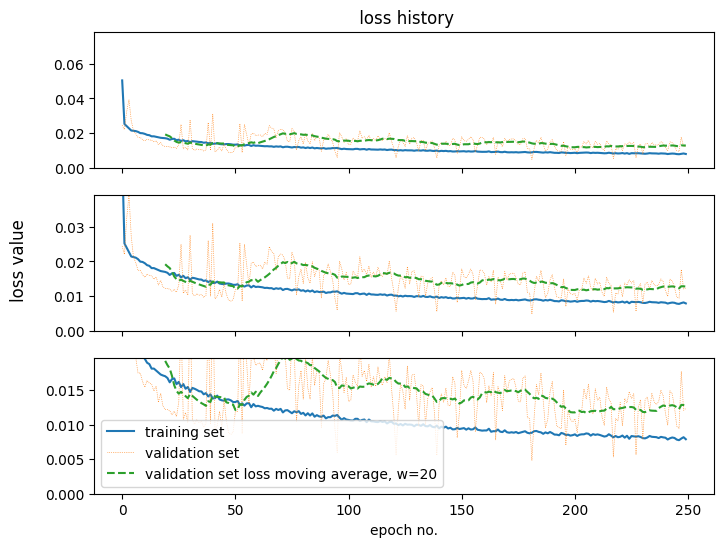

In [22]:
plot_loss_history(history, (20,))

In [69]:
model.predict(points[:5])

1/1 [==============================] - 0s 60ms/step


array([[-1.1939905],
       [-2.9469774],
       [ 1.6012647],
       [ 2.0283613],
       [-1.1413008]], dtype=float32)

In [70]:
model.save_weights('/host/dissertation/trained_models/phi_model_weights.h5', save_format='h5')
model = get_model()
model.load_weights('/host/dissertation/trained_models/phi_model_weights.h5')

model.predict(points[:5])

1/1 [==============================] - 0s 58ms/step


array([[-1.1939905],
       [-2.9469774],
       [ 1.6012647],
       [ 2.0283613],
       [-1.1413008]], dtype=float32)

## space search

In [78]:
TAIL_SIZE = 20
EPOCHS_NUM = 250

spacepoints_number_space = [3,6,10]
hiddenlayers_number_space = [1,2,3]
layer_neurons_number_space = [32,64,96,128]
layer_activation_func_space = ['pol_tanh','pol_sigmoid','cart_tanh','cart_sigmoid','cart_relu',] #['cart_relu']#

import itertools
hp_list = list(itertools.product(spacepoints_number_space,hiddenlayers_number_space,layer_neurons_number_space,layer_activation_func_space))
param = {'spacepoints_number': 0, 'hidden_layers': 1, 'neurons_num': 2, 'activation_func': 3}

In [79]:
import os 
import time

TIMESTAMP = int(time.time())
WORKING_DIRECTORY = f'/host/dissertation/trained_models/{TIMESTAMP}/'
os.umask(0)
os.mkdir(WORKING_DIRECTORY, mode=0o777)
os.mkdir(WORKING_DIRECTORY + 'history/', mode=0o777)
os.mkdir(WORKING_DIRECTORY + 'weights/', mode=0o777)

import csv
HP_FILEPATH = WORKING_DIRECTORY + 'q_hp.csv'
with open(HP_FILEPATH, 'w', newline='', opener=lambda path, flags: os.open(path, flags, 0o777)) as f:
    hp_file_columns = ['hp_config','time','val_loss-avg','val_loss-med','val_loss-std','train_loss-max','train_loss-min']
    csv.writer(f).writerow(hp_file_columns)

In [80]:
def hp_string(config):
    return str(config).translate(str.maketrans(',','-'," '()"))
def get_history_filename(config):
    return 'history/' + hp_string(config) + '-history.csv'
def get_weights_filename(config):
    return 'weights/' + hp_string(config) + '-weights.h5'

get_history_filename((1, 32, 'cart_relu'))

'history/1-32-cart_relu-history.csv'

In [81]:
def append_hp_file(hp_config, df):
    val_loss_tail = df['val_loss'][-TAIL_SIZE:]
    loss_tail = df['loss'][-TAIL_SIZE:]
    
    with open(HP_FILEPATH, 'a', newline='') as f:
        csv.writer(f).writerow([hp_string(hp_config),time.strftime("%H:%M:%S", time.localtime()),np.average(val_loss_tail),np.median(val_loss_tail),np.std(val_loss_tail),np.max(loss_tail),np.min(loss_tail)])

In [82]:
import cvnn.layers as complex_layers

for hp in hp_list:
    print('START', hp)
    model = tf.keras.models.Sequential()
    model.add(complex_layers.ComplexInput(input_shape=(hp[param['spacepoints_number']],)))
    for layer_no in range(hp[param['hidden_layers']]):
        model.add(complex_layers.ComplexDense(units=hp[param['neurons_num']], activation=hp[param['activation_func']]))
    model.add(complex_layers.ComplexDense(units=1, activation=activation_phase))
    model.compile(optimizer=tf.keras.optimizers.SGD(clipnorm=1.), loss=AngleError())
    print('      model compiled')
    points = np.load('/host/dissertation/proccessed_data/points_' + str(hp[param['spacepoints_number']]) + '.npy')
    print('      training...')
    history = model.fit(points, phi, epochs=EPOCHS_NUM, validation_split=0.2, verbose=0, callbacks=[FreeMemory()])
    print('      model trained')
    df = make_dataframe(history)
    append_hp_file(hp, df)
    print('      hp_file appended')
    df.to_csv(WORKING_DIRECTORY + get_history_filename(hp), index=False)
    print('      history saved')
    model.save_weights(WORKING_DIRECTORY + get_weights_filename(hp), save_format='h5')
    print('      weights saved')
    print('DONE ', hp)

START (3, 1, 32, 'pol_tanh')
      model compiled
      training...
      model trained
      hp_file appended
      history saved
      weights saved
DONE  (3, 1, 32, 'pol_tanh')
START (3, 1, 32, 'pol_sigmoid')
      model compiled
      training...
      model trained
      hp_file appended
      history saved
      weights saved
DONE  (3, 1, 32, 'pol_sigmoid')
START (3, 1, 32, 'cart_tanh')
      model compiled
      training...
      model trained
      hp_file appended
      history saved
      weights saved
DONE  (3, 1, 32, 'cart_tanh')
START (3, 1, 32, 'cart_sigmoid')
      model compiled
      training...
      model trained
      hp_file appended
      history saved
      weights saved
DONE  (3, 1, 32, 'cart_sigmoid')
START (3, 1, 32, 'cart_relu')
      model compiled
      training...
      model trained
      hp_file appended
      history saved
      weights saved
DONE  (3, 1, 32, 'cart_relu')
START (3, 1, 64, 'pol_tanh')
      model compiled
      training...
      model tr